# EXPERIMENTAL CLASSIFICATION WITH A COMPOSITION OF DIFFERENT MODELS 

by ChunkDevs (Group 1)

Ensemble learning uses multiple learning algorithms to obtain better predictive performance than
could be obtained from any of the constituent learning algorithms alone by reducing the variance of
single model. It is also one of the most popular
approaches used by winners in many machine learning competitions.

**Bagging, boosting and stacking**
are three most widely used ensemble types.


In this notebook, we load our presaved models, predict on the test set, and combine their predictions using the arithmetic average. Finally, we will compare the ensemble predictions with the true labels. 

In [17]:
import os
import sys

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

from _chunkdevs.models import ModelHandler, ChunkDevs_Transformer, Build_Handle
from _chunkdevs.data_functions import *

In [3]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

model_path = os.path.join(root_path, "outputs", "models")

In [4]:
X_dev = dev["tweet_text_cleaned"]
X_test = test["tweet_text"]

y_dev_bin = dev["cyberbullying_type_bin"]
y_test_bin = test["cyberbullying_type_bin"]

In [5]:
def ensemble_arithmetic_average(model1_preds, model2_preds):

    return np.round(np.mean(np.array([model1_preds, model2_preds]), axis=0)).astype(int)

# MODELS LOADING

We loaded our pretrained models, using our `ModelHandler` class of our library.

In [ ]:
RANDOM_STATE = 42
VAL_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
EPS = 1e-8

labels_name_bin = ["not_cyberbullying", "cyberbullying"]
labels_name_multi = ["age", "ethnicity", "gender", "not_cyberbullying", "other_cyberbullying", "religion"]

In [6]:
handler = ModelHandler(model_path)
models_dict = handler.load_models(["Bert_binary", "Roberta_binary"])


In [7]:
BERT_BIN_MODEL = models_dict["Bert_binary"]
ROBERTA_BIN_MODEL = models_dict["Roberta_binary"]

# VOTING SCHEMA ATTEMPT

## BINARY: BERT, ROBERTA AND ARITHMETIC MEAN AS A COMBINER

Since only 2 models have been used during this ensemble approach, it is necessary to consider that if they give a different prediction, the tweet will be classified as a not cyberbullying message, since the np.round(np.mean([0,1])) = 0. 
The reason of this choice is to try avoiding the false flagging phenomenon, which is one of the most common harms of ML classificication models

### BERT DATA LOADING

In [8]:
build_test = Build_Handle(test["tweet_text"], test["cyberbullying_type_bin"], tokenizer=BERT_BIN_MODEL.tokenizer)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

### ROBERTA DATALOADING


In [9]:
rob_build_test = Build_Handle(test["tweet_text"], test["cyberbullying_type_bin"], tokenizer=ROBERTA_BIN_MODEL.tokenizer)
rob_dataloader_test = DataLoader(rob_build_test, batch_size=BATCH_SIZE)

### PREDICTION PHASE

In [10]:
bert_preds = BERT_BIN_MODEL.predict(dataloader_test)

PREDICTING:: 2928it [00:07, 382.04it/s]                                                             8.90it/s]

Prediction completed


In [11]:
roberta_preds = ROBERTA_BIN_MODEL.predict(rob_dataloader_test)

PREDICTING:: 2928it [00:06, 427.43it/s]                                                             7.89it/s]

Prediction completed


In [18]:
models_preds_df = pd.DataFrame({"bert": bert_preds, 
                    "roberta" : roberta_preds, 
                    "labels": y_test_bin})

In [19]:
averaged_preds = ensemble_arithmetic_average(bert_preds, roberta_preds)
averaged_preds

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
print('Classification Report for AVERAGE_PREDS :\n', classification_report(y_test_bin, averaged_preds, target_names = labels_name_bin))

Classification Report for AVERAGE_PREDS :
                    precision    recall  f1-score   support

not_cyberbullying       0.52      0.83      0.64       487
    cyberbullying       0.96      0.85      0.90      2435

         accuracy                           0.85      2922
        macro avg       0.74      0.84      0.77      2922
     weighted avg       0.89      0.85      0.86      2922



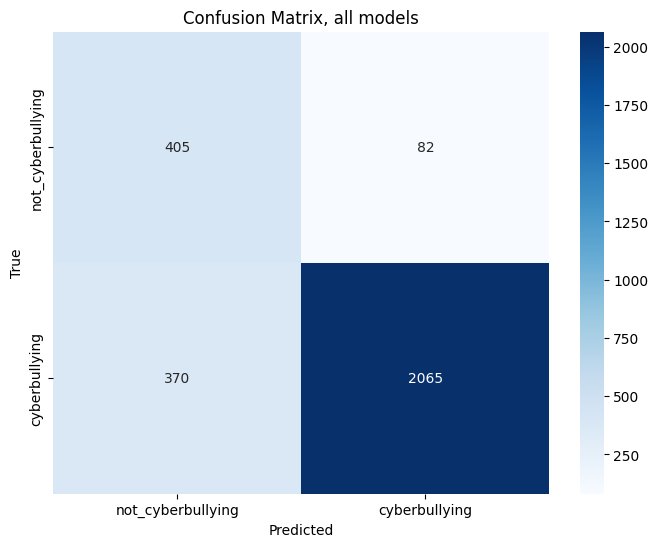

In [21]:
cm = confusion_matrix(y_test_bin, averaged_preds)

# Plotta la confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name_bin, yticklabels=labels_name_bin)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix, all models')
    
#plt.savefig('Multi_rob_bin.png')
plt.show()
#plt.close()

Judging by the results, this ensemble has equal a slightly higher f1-score, due to the high value of recall. Therefore, this model tends to classify as not cyberbullying a notable amount of cyberbullying messages, but it is less suffering from the false flagging phenomena. 